#### Module import & Load Data

In [85]:
# 메모리내 변수 제거

all = [var for var in globals() if var[0] != "_"]   # globals() 목록의 첫글자가 _ 로 시작하지 않는 자료의 리스트만 가져와서
for var in all:
    del globals()[var]

In [86]:
import pandas as pd
import numpy as np

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

import wordcloud
import nltk
# import seaborn as sns
import re

import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score

In [87]:
train1 = pd.read_csv('c:/data/project/train.csv')
test = pd.read_csv('c:/data/project/test.csv')

In [88]:
train = train1.copy()
train_first_second = train1.copy()
train.info()
train.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2478 entries, 0 to 2477
Data columns (total 5 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   ID                  2478 non-null   object
 1   first_party         2478 non-null   object
 2   second_party        2478 non-null   object
 3   facts               2478 non-null   object
 4   first_party_winner  2478 non-null   int64 
dtypes: int64(1), object(4)
memory usage: 96.9+ KB


,ID,first_party,second_party,facts,first_party_winner
0,TRAIN_0000,Phil A. St. Amant,Herman A. Thompson,"On June 27, 1962, Phil St. Amant, a candidate ...",1
1,TRAIN_0001,Stephen Duncan,Lawrence Owens,Ramon Nelson was riding his bike when he suffe...,0
2,TRAIN_0002,Billy Joe Magwood,"Tony Patterson, Warden, et al.",An Alabama state court convicted Billy Joe Mag...,1
3,TRAIN_0003,Linkletter,Walker,Victor Linkletter was convicted in state court...,0
4,TRAIN_0004,William Earl Fikes,Alabama,"On April 24, 1953 in Selma, Alabama, an intrud...",1


In [89]:
train.drop(columns=['ID', 'first_party', 'second_party'], inplace=True)
# train.head()
# train['first_party_winner'].value_counts()

train_first_second.drop(columns=['ID','facts','first_party_winner'], inplace=True)

In [90]:
train_target = pd.DataFrame(train, columns=['first_party_winner'])
# train_target

first_party_winner
1    1649
0     829
Name: count, dtype: int64


<Axes: ylabel='Type'>

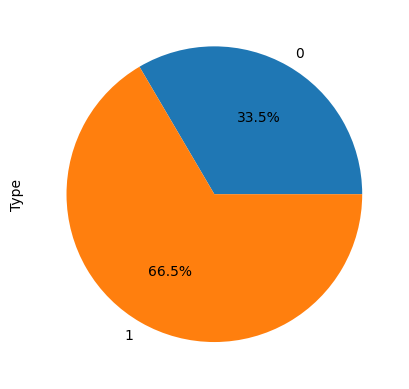

In [91]:
print(train_target["first_party_winner"].value_counts())

train_target.groupby('first_party_winner').size().plot(kind='pie',
                                       y = "first_party_winner",
                                       label = "Type",
                                       autopct='%1.1f%%')

In [92]:
train_nlp = train['facts']
train_nlp = pd.DataFrame(train_nlp, columns=['facts'])
train_nlp['facts'] = train_nlp['facts'].str.replace(r'<[^<>]*>', '', regex=True)
train_nlp

,facts
0,"On June 27, 1962, Phil St. Amant, a candidate ..."
1,Ramon Nelson was riding his bike when he suffe...
2,An Alabama state court convicted Billy Joe Mag...
3,Victor Linkletter was convicted in state court...
4,"On April 24, 1953 in Selma, Alabama, an intrud..."
...,...
2473,Congress amended the Clean Air Act through the...
2474,"Alliance Bond Fund, Inc., an investment fund, ..."
2475,"In 1992, the District Court sentenced Manuel D..."
2476,"On March 8, 1996, Enrico St. Cyr, a lawful per..."


#### 토큰화 확인

In [93]:
# corpus = train_nlp["facts"]
# lst_tokens = nltk.tokenize.word_tokenize(corpus.str.cat(sep=" "))
# 어절 별로 키워드 반환
# lst_tokens

### 불용어 사전 정의 (사용자 지정 & 기본 제공[english])

In [94]:
##### 불용어 처리 및 어간과 표제어 추출 함수 #####

def utils_preprocess_text(text, flg_stemm=False, flg_lemm=True, lst_stopwords=None): 
## clean (convert to lowercase and remove punctuations and characters and then strip)
    text = re.sub(r'[^\w\s]', '', str(text).lower().strip())
    # 정규식, 치환 문자열, src 문자열 입력 -> 해당 문자가 발견되지 않는 경우 space bar로 변환, 단어별 split을 위한 작업
            
    ## Tokenize (convert from string to list)
    lst_text = text.split()    ## remove Stopwords
    if lst_stopwords is not None:
        lst_text = [word for word in lst_text if word not in 
                    lst_stopwords]
                        
    ## Stemming (remove -ing, -ly, ...)
    if flg_stemm == True:
        ps = nltk.stem.porter.PorterStemmer()
        lst_text = [ps.stem(word) for word in lst_text]
                
    ## Lemmatisation (convert the word into root word)
    if flg_lemm == True:
        lem = nltk.stem.wordnet.WordNetLemmatizer()
        lst_text = [lem.lemmatize(word) for word in lst_text]
            
    ## back to string from list
    text = " ".join(lst_text)
    return text

In [95]:
##### 단어와 빈도수 측정 및 시각화 함수 #####

def word_freq(data, columns, titleName=None, graph=False):
    corpus = data[columns]
    lst_tokens = nltk.tokenize.word_tokenize(corpus.str.cat(sep=" "))

    dic_word_freq = nltk.FreqDist(lst_tokens)
    words_freq = pd.DataFrame(dic_word_freq.most_common(), columns=["Word","Freq"])

    if graph==True:
        fig, ax = plt.subplots(nrows=1, ncols=1)
        fig.suptitle('Most frequent words'+titleName, fontsize=15)
        figure(figsize=(30, 24))
        
        words_freq.set_index("Word").iloc[:30,:].sort_values(by="Freq").plot(
                  kind="barh", title="words", ax=ax, 
                  legend=False).grid(axis='x')
               
        ax.set(ylabel=None)
        plt.show()
    
    return [words_freq, dic_word_freq]

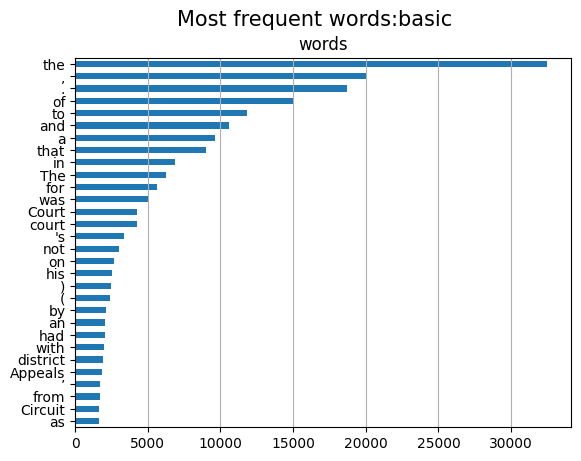

<Figure size 3000x2400 with 0 Axes>

,Word,Freq
0,the,32500
1,",",20104
2,.,18697
3,of,15057
4,to,11798
...,...,...
21425,patentee,1
21426,localize,1
21427,spurious,1
21428,bar-coded,1


In [96]:
word_freq(train_nlp, 'facts', ':basic', True)[0]

##### 기본 불용어 처리

In [97]:
lst_stopwords = nltk.corpus.stopwords.words("english")
# NLTK가 정의한 영어 불용어 리스트를 리턴

train_nlp["facts"] = train_nlp["facts"].apply(lambda x: utils_preprocess_text(x, flg_stemm=False, flg_lemm=True, lst_stopwords=lst_stopwords))
# nltk 기본 불용어를 제거한 결과
train_nlp

,facts
0,june 27 1962 phil st amant candidate public of...
1,ramon nelson riding bike suffered lethal blow ...
2,alabama state court convicted billy joe magwoo...
3,victor linkletter convicted state court eviden...
4,april 24 1953 selma alabama intruder broke apa...
...,...
2473,congress amended clean air act energy policy a...
2474,alliance bond fund inc investment fund purchas...
2475,1992 district court sentenced manuel peguero 2...
2476,march 8 1996 enrico st cyr lawful permanent re...


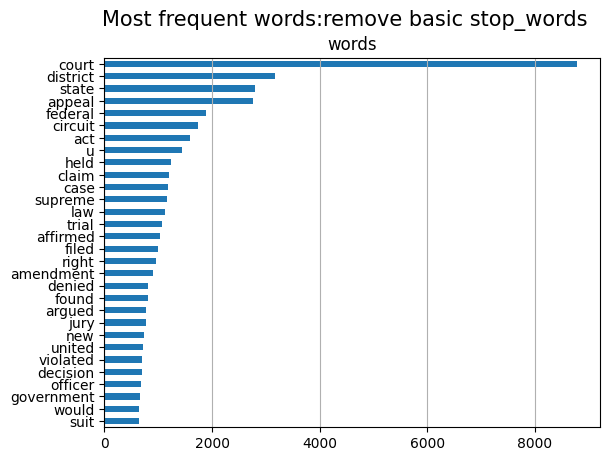

<Figure size 3000x2400 with 0 Axes>

,Word,Freq
0,court,8776
1,district,3168
2,state,2793
3,appeal,2757
4,federal,1886
...,...,...
18013,patentee,1
18014,localize,1
18015,spurious,1
18016,barcoded,1


In [98]:
word_freq(train_nlp, 'facts', ':remove basic stop_words',True)[0]

##### 사용자 정의 불용어 사전 적용

In [99]:
def user_stopwords(dic):
    stop_words=[]
    for word, freq in dic.most_common():
        if freq == 1:
            stop_words.append(word)
    return stop_words

In [100]:
dic_words_freq = word_freq(train_nlp, 'facts', False)[1]

stop_words=user_stopwords(dic_words_freq)
stop_words

['amants',
 'utter',
 'uninhibited',
 'robust',
 'happens',
 'unreliability',
 'owens',
 'interrogator',
 'tipping',
 'flowing',
 'trucked',
 'disrupting',
 'cargohandling',
 'barnetts',
 'senioritybased',
 'nondisabled',
 '1796',
 'paty',
 'mcdaniels',
 'meetingcompetition',
 '2b',
 'preapproval',
 '382',
 'householder',
 'thole',
 '404',
 '405',
 'overfunded',
 'undertake',
 'compiled',
 'guillens',
 'guillen',
 'educating',
 '1001',
 'exercisable',
 'martinezsalazars',
 'seating',
 'curatively',
 'complement',
 'headon',
 'alexa',
 'thanh',
 'mazda',
 'cassius',
 'tentatively',
 'conscientiously',
 'citigroups',
 'chemistry',
 'bassam',
 'yacoub',
 'karim',
 'antifish',
 'trapping',
 'trapped',
 'kake',
 'moor',
 'antitrapping',
 'dude',
 'intermingled',
 'regrant',
 'multimillion',
 'predated',
 'hiram',
 'extinction',
 'monitored',
 'selectiveprosecution',
 'stoltnielsen',
 'reevaluated',
 'terrorize',
 'empaneled',
 'bv',
 'herkimer',
 'locallyproduced',
 'publiclyowned',
 'sligh

In [101]:
train_nlp["facts"] = train_nlp["facts"].apply(lambda x: utils_preprocess_text(x, flg_stemm=False, flg_lemm=True, lst_stopwords=stop_words))
train_nlp

,facts
0,june 27 1962 phil st amant candidate public of...
1,ramon nelson riding bike suffered lethal blow ...
2,alabama state court convicted billy joe magwoo...
3,victor linkletter convicted state court eviden...
4,april 24 1953 selma alabama intruder broke apa...
...,...
2473,congress amended clean air act energy policy a...
2474,alliance bond fund inc investment fund purchas...
2475,1992 district court sentenced manuel peguero 2...
2476,march 8 1996 st cyr lawful permanent resident ...


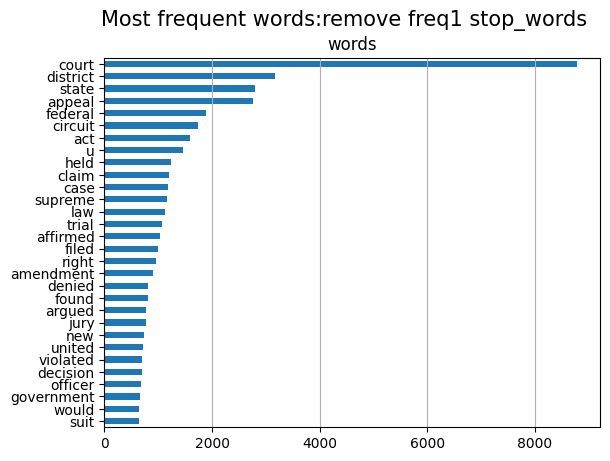

<Figure size 3000x2400 with 0 Axes>

,Word,Freq
0,court,8776
1,district,3168
2,state,2793
3,appeal,2757
4,federal,1886
...,...,...
11264,drycleaning,2
11265,keyboard,2
11266,optical,2
11267,markmans,2


In [102]:
word_freq(train_nlp, 'facts', ':remove freq1 stop_words',True)[0]

#### 승소, 패소 시의 단어 빈도수 확인

###### 위의 전처리 과정에서 얻은 facts와 first_party_winner만 남긴 데이터 프레임을 train_nlp2로 지정함

In [103]:
train_nlp = pd.concat([train_nlp,train_target['first_party_winner']],axis=1, join='inner')
train_nlp

,facts,first_party_winner
0,june 27 1962 phil st amant candidate public of...,1
1,ramon nelson riding bike suffered lethal blow ...,0
2,alabama state court convicted billy joe magwoo...,1
3,victor linkletter convicted state court eviden...,0
4,april 24 1953 selma alabama intruder broke apa...,1
...,...,...
2473,congress amended clean air act energy policy a...,1
2474,alliance bond fund inc investment fund purchas...,1
2475,1992 district court sentenced manuel peguero 2...,0
2476,march 8 1996 st cyr lawful permanent resident ...,0


##### 승소 시 단어 빈도 수 -> 빈도수가 1인 단어가 꽤 존재함 -> 이를 제거할지 고민해봐야함

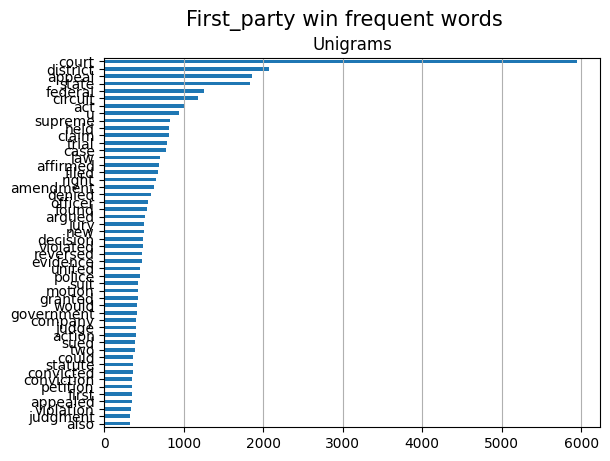

<Figure size 3000x2400 with 0 Axes>

,Word,Freq
0,court,5943
1,district,2071
2,appeal,1856
3,state,1827
4,federal,1250
...,...,...
9942,succeeded,1
9943,tucson,1
9944,formulate,1
9945,elective,1


In [104]:
y=1
corpus1 = train_nlp[train_nlp["first_party_winner"]== y]["facts"]
first_tokens = nltk.tokenize.word_tokenize(corpus1.str.cat(sep=" "))

fig, ax = plt.subplots(nrows=1, ncols=1)
fig.suptitle("First_party win frequent words", fontsize=15)
figure(figsize=(30, 24))

first_words_freq = nltk.FreqDist(first_tokens)
dtf_uni1 = pd.DataFrame(first_words_freq.most_common(), columns=["Word","Freq"])
dtf_uni1.set_index("Word").iloc[:50,:].sort_values(by="Freq").plot(
                  kind="barh", title="Unigrams", ax=ax, 
                  legend=False).grid(axis='x')
ax.set(ylabel=None)
plt.show()    

dtf_uni1
# first_win_words = dtf_uni1['Word'][:50]

##### 패소 시 단어 빈도 수

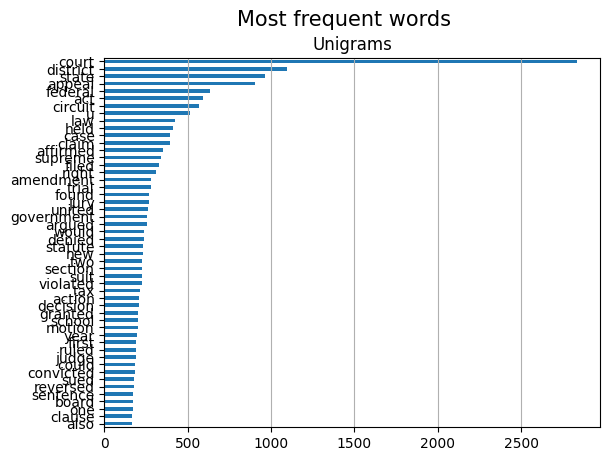

<Figure size 3000x2400 with 0 Axes>

,Word,Freq
0,court,2833
1,district,1097
2,state,966
3,appeal,901
4,federal,636
...,...,...
10082,localize,1
10083,spurious,1
10084,barcoded,1
10085,westviews,1


In [28]:
y=0
corpus0 = train_nlp[train_nlp["first_party_winner"]== y]["facts"]
lst_tokens = nltk.tokenize.word_tokenize(corpus0.str.cat(sep=" "))

fig, ax = plt.subplots(nrows=1, ncols=1)
fig.suptitle("Most frequent words", fontsize=15)
figure(figsize=(30, 24))

dic_words_freq = nltk.FreqDist(lst_tokens)
dtf_uni0 = pd.DataFrame(dic_words_freq.most_common(), columns=["Word","Freq"])
dtf_uni0.set_index("Word").iloc[:50,:].sort_values(by="Freq").plot(
                  kind="barh", title="Unigrams", ax=ax, 
                  legend=False).grid(axis='x')
ax.set(ylabel=None)
plt.show()    

dtf_uni0

In [ ]:
# dtf_uni0[:50] == dtf_uni1[:50]

#### Wordcloud

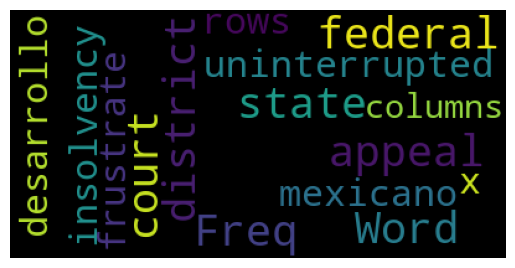

In [29]:
wc1 = wordcloud.WordCloud(background_color='black', max_words=100, 
                         max_font_size=35)
wc1 = wc1.generate(str(dtf_uni1))
fig = plt.figure(num=1)
plt.axis('off')
plt.imshow(wc1, cmap=None)
plt.show()

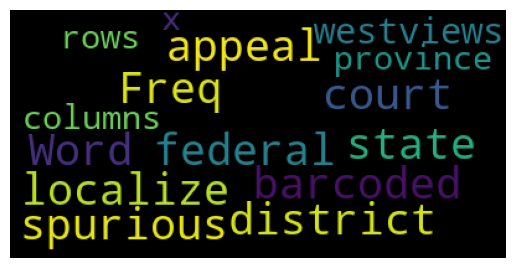

In [30]:
wc0 = wordcloud.WordCloud(background_color='black', max_words=100, 
                         max_font_size=35)
wc0 = wc0.generate(str(dtf_uni0))
fig = plt.figure(num=1)
plt.axis('off')
plt.imshow(wc0, cmap=None)
plt.show()

## Define Model & Train

In [31]:
train_first_second["first_party"] = train_first_second["first_party"].apply(lambda x: utils_preprocess_text(x, flg_stemm=False, flg_lemm=True))
train_first_second["second_party"] = train_first_second["second_party"].apply(lambda x: utils_preprocess_text(x, flg_stemm=False, flg_lemm=True))
train_first_second

,first_party,second_party
0,phil a st amant,herman a thompson
1,stephen duncan,lawrence owen
2,billy joe magwood,tony patterson warden et al
3,linkletter,walker
4,william earl fikes,alabama
...,...,...
2473,hollyfrontier cheyenne refining llc et al,renewable fuel association et al
2474,grupo mexicano de desarrollo s a,alliance bond fund inc
2475,peguero,united state
2476,immigration and naturalization service,st cyr


In [32]:
# train_nlp = pd.concat([train_nlp,train1['first_party'],train1['second_party']],axis=1, join='inner')
train_nlp = pd.concat([train_nlp,train_first_second['first_party'],train_first_second['second_party']],axis=1, join='inner')
train_nlp

,facts,first_party_winner,first_party,second_party
0,june 27 1962 phil st amant candidate public of...,1,phil a st amant,herman a thompson
1,ramon nelson riding bike suffered lethal blow ...,0,stephen duncan,lawrence owen
2,alabama state court convicted billy joe magwoo...,1,billy joe magwood,tony patterson warden et al
3,victor linkletter convicted state court eviden...,0,linkletter,walker
4,april 24 1953 selma alabama intruder broke apa...,1,william earl fikes,alabama
...,...,...,...,...
2473,congress amended clean air act energy policy a...,1,hollyfrontier cheyenne refining llc et al,renewable fuel association et al
2474,alliance bond fund inc investment fund purchas...,1,grupo mexicano de desarrollo s a,alliance bond fund inc
2475,1992 district court sentenced manuel peguero 2...,0,peguero,united state
2476,march 8 1996 enrico st cyr lawful permanent re...,0,immigration and naturalization service,st cyr


In [33]:
vectorizer = TfidfVectorizer()

def get_vector(vectorizer, df, train_mode):
    if train_mode:
        X_facts = vectorizer.fit_transform(df['facts'])
    else:
        X_facts = vectorizer.transform(df['facts'])
    X_party1 = vectorizer.transform(df['facts'])
    X_party2 = vectorizer.transform(df['facts'])
    
    X = np.concatenate([X_party1.todense(), X_party2.todense(), X_facts.todense()], axis=1)
    return X

X = get_vector(vectorizer, train_nlp, True)
ylabel = train_nlp["first_party_winner"]

In [34]:
from sklearn.model_selection import train_test_split

X_train, X_eval, y_train, y_eval = train_test_split(X, ylabel, test_size=0.25, random_state=11)
X_train

matrix([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]])

In [ ]:
y_eval.value_counts()

### LogisticRegression

In [35]:
# lr = LogisticRegression(solver='liblinear', class_weight = 'balanced')
lr = LogisticRegression() # option 지정을 안 하니 성능이 더 좋아짐 -> accuracy : 0.643548, test 적용 시 1: 1124, 0: 116
lr.fit(np.asarray(X_train), y_train)

LogisticRegression()

In [41]:
print("LR Accuracy : %f" % lr.score(np.asarray(X_eval), y_eval)) # 검증 데이터로 성능 측정
accuracy_score(y_eval, lr.predict(np.asarray(X_eval)))
f1_score(y_eval, lr.predict(np.asarray(X_eval)))

LR Accuracy : 0.645161


0.7764227642276423

In [44]:
test_lr = pd.DataFrame(lr.predict(np.asarray(X_eval)))
test_lr.value_counts()

1    572
0     48
Name: count, dtype: int64

### FLAML

In [52]:
from flaml import AutoML

automl = AutoML()
automl.fit(np.asarray(X_train), y_train, task="classification", time_budget=60)

[flaml.automl.logger: 06-20 13:10:34] {1693} INFO - task = classification
[flaml.automl.logger: 06-20 13:10:34] {1700} INFO - Data split method: stratified
[flaml.automl.logger: 06-20 13:10:34] {1703} INFO - Evaluation method: holdout
[flaml.automl.logger: 06-20 13:10:35] {1801} INFO - Minimizing error metric: 1-roc_auc
[flaml.automl.logger: 06-20 13:10:35] {1911} INFO - List of ML learners in AutoML Run: ['lgbm', 'rf', 'xgboost', 'extra_tree', 'xgb_limitdepth', 'lrl1']
[flaml.automl.logger: 06-20 13:10:35] {2221} INFO - iteration 0, current learner lgbm
[flaml.automl.logger: 06-20 13:10:36] {2347} INFO - Estimated sufficient time budget=6972s. Estimated necessary time budget=161s.
[flaml.automl.logger: 06-20 13:10:36] {2394} INFO -  at 1.7s,	estimator lgbm's best error=0.5119,	best estimator lgbm's best error=0.5119
[flaml.automl.logger: 06-20 13:10:36] {2221} INFO - iteration 1, current learner lgbm
[flaml.automl.logger: 06-20 13:10:37] {2394} INFO -  at 2.2s,	estimator lgbm's best e

c:\Users\user\miniconda3\envs\py\Lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[flaml.automl.logger: 06-20 13:11:06] {2394} INFO -  at 31.2s,	estimator xgboost's best error=0.4975,	best estimator lgbm's best error=0.4763
[flaml.automl.logger: 06-20 13:11:06] {2221} INFO - iteration 4, current learner lgbm
[flaml.automl.logger: 06-20 13:11:06] {2394} INFO -  at 32.0s,	estimator lgbm's best error=0.4568,	best estimator lgbm's best error=0.4568
[flaml.automl.logger: 06-20 13:11:06] {2221} INFO - iteration 5, current learner lgbm
[flaml.automl.logger: 06-20 13:11:07] {2394} INFO -  at 32.8s,	estimator lgbm's best error=0.4568,	best estimator lgbm's best error=0.4568
[flaml.automl.logger: 06-20 13:11:07] {2221} INFO - iteration 6, current learner lgbm
[flaml.automl.logger: 06-20 13:11:08] {2394} INFO -  at 33.8s,	estimator lgbm's best error=0.4377,	best estimator lgbm's best error=0.4377
[flaml.automl.logger: 06-20 13:11:08] {2221} INFO - iteration 7, current learner extra_tree
[flaml.automl.logger: 06-20 13:11:09] {2394} INFO -  at 34.2s,	estimator extra_tree's best 

In [53]:
print('Best ML model:', automl.model)
print('Best hyperparameter config:', automl.best_config)
print('Best accuracy on validation data: {0:.4g}'.format(1-automl.best_loss))
print('Training duration of best run: {0:.4g} s'.format(automl.best_config_train_time))

Best ML model: <flaml.automl.model.ExtraTreesEstimator object at 0x0000022F9C1E2DD0>
Best hyperparameter config: {'n_estimators': 22, 'max_features': 0.007767272225213948, 'max_leaves': 11, 'criterion': 'gini'}
Best accuracy on validation data: 0.5731
Training duration of best run: 1.079 s


In [54]:
automl.model.estimator

ExtraTreesClassifier(max_features=0.007767272225213948, max_leaf_nodes=11,
                     n_estimators=22, n_jobs=-1, random_state=12032022)

In [55]:
print("Automl Accuracy : %f" % automl.score(np.asarray(X_eval), y_eval)) # 검증 데이터로 성능 측정
accuracy_score(y_eval, automl.predict(np.asarray(X_eval)))
f1_score(y_eval, automl.predict(np.asarray(X_eval)))

Automl Accuracy : 0.664516


0.7984496124031008

### Test csv 적용

In [45]:
test.head()

,ID,first_party,second_party,facts
0,TEST_0000,Salerno,United States,The 1984 Bail Reform Act allowed the federal c...
1,TEST_0001,Milberg Weiss Bershad Hynes and Lerach,"Lexecon, Inc.",Lexecon Inc. was a defendant in a class action...
2,TEST_0002,No. 07-582\t Title: \t Federal Communications ...,"Fox Television Stations, Inc., et al.","In 2002 and 2003, Fox Television Stations broa..."
3,TEST_0003,Harold Kaufman,United States,During his trial for armed robbery of a federa...
4,TEST_0004,Berger,Hanlon,"In 1993, a magistrate judge issued a warrant a..."


In [46]:
test["first_party"] = test["first_party"].apply(lambda x: utils_preprocess_text(x, flg_stemm=False, flg_lemm=True))
test["second_party"] = test["second_party"].apply(lambda x: utils_preprocess_text(x, flg_stemm=False, flg_lemm=True))
test

,ID,first_party,second_party,facts
0,TEST_0000,salerno,united state,The 1984 Bail Reform Act allowed the federal c...
1,TEST_0001,milberg wei bershad hynes and lerach,lexecon inc,Lexecon Inc. was a defendant in a class action...
2,TEST_0002,no 07582 title federal communication commissio...,fox television station inc et al,"In 2002 and 2003, Fox Television Stations broa..."
3,TEST_0003,harold kaufman,united state,During his trial for armed robbery of a federa...
4,TEST_0004,berger,hanlon,"In 1993, a magistrate judge issued a warrant a..."
...,...,...,...,...
1235,TEST_1235,haitian center council inc et al,chris sale acting commissioner immigration and...,According to Executive Order No. 12807 signed ...
1236,TEST_1236,whitman,american trucking association inc,Section 109(a) of the Clean Air Act (CAA) requ...
1237,TEST_1237,linda a matteo and john j madigan,william g barr,Linda Matteo and John Madigan created a plan f...
1238,TEST_1238,washington state apple advertising commission,hunt,"In 1972, the North Carolina Board of Agricultu..."


In [47]:
dfTest = pd.DataFrame(test['facts'])
dfTest['facts'] = dfTest['facts'].str.replace(r'<[^<>]*>', '', regex=True)
dfTest["facts"] = dfTest["facts"].apply(lambda x: utils_preprocess_text(x, flg_stemm=False, flg_lemm=True, lst_stopwords=lst_stopwords))
dfTest = pd.concat([dfTest,test['first_party'],test['second_party']],axis=1, join='inner')
dfTest['first_party_winner'] = np.zeros(len(dfTest)).astype(int)
dfTest

,facts,first_party,second_party,first_party_winner
0,1984 bail reform act allowed federal court det...,salerno,united state,0
1,lexecon inc defendant class action lawsuit 28 ...,milberg wei bershad hynes and lerach,lexecon inc,0
2,2002 2003 fox television station broadcast bil...,no 07582 title federal communication commissio...,fox television station inc et al,0
3,trial armed robbery federally insured saving l...,harold kaufman,united state,0
4,1993 magistrate judge issued warrant authorizi...,berger,hanlon,0
...,...,...,...,...
1235,according executive order 12807 signed preside...,haitian center council inc et al,chris sale acting commissioner immigration and...,0
1236,section 109a clean air act caa requires enviro...,whitman,american trucking association inc,0
1237,linda matteo john madigan created plan utilizi...,linda a matteo and john j madigan,william g barr,0
1238,1972 north carolina board agriculture adopted ...,washington state apple advertising commission,hunt,0


In [48]:
X_test = get_vector(vectorizer, dfTest, False)
y_test = dfTest["first_party_winner"]
X_test

matrix([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]])

In [49]:
y_pred_test = lr.predict((np.asarray(X_test)))
predcsv = pd.DataFrame(y_pred_test,columns=['first_party_winner'])
predcsv.value_counts()

first_party_winner
1                     1132
0                      108
Name: count, dtype: int64

In [57]:
y_pred_test = automl.predict((np.asarray(X_test)))
predcsv = pd.DataFrame(y_pred_test,columns=['first_party_winner'])
predcsv.value_counts()

first_party_winner
1                     1240
Name: count, dtype: int64

## Inference & Submission

In [51]:
submit = pd.read_csv('C:/data/project/sample_submission.csv')
submit['first_party_winner'] = predcsv
submit.to_csv('./sample_submission.csv', index=False)
print('Done')

Done
